In [1]:
%matplotlib inline
import numpy as np
import os
import pycs3.gen.lc_func
import pycs3.gen.splml
import pycs3.gen.mrg
import pycs3.spl.topopt
import pycs3.regdiff.multiopt
import pycs3.regdiff.rslc
import pycs3.gen.util
import pycs3.sim.draw
import pycs3.sim.run
import pycs3.sim.plot
import pycs3.sim.twk
import pycs3.tdcomb.plot
import pycs3.tdcomb.comb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
loggerformat='%(message)s'
logging.basicConfig(format=loggerformat,level=logging.INFO)

# plt.rcParams.update({'text.usetex': True})


In [3]:
rdbfile = '../data/RXJ1131_Tewes2013.txt'
rxj1131_lcs = [
        pycs3.gen.lc_func.rdbimport(rdbfile, object='A', magcolname='mag_A', magerrcolname='magerr_A', telescopename='RXJ1131'),
        pycs3.gen.lc_func.rdbimport(rdbfile, object='B', magcolname='mag_B', magerrcolname='magerr_B', telescopename='RXJ1131'),
        pycs3.gen.lc_func.rdbimport(rdbfile, object='C', magcolname='mag_C', magerrcolname='magerr_C', telescopename='RXJ1131'),
        pycs3.gen.lc_func.rdbimport(rdbfile, object='D', magcolname='mag_D', magerrcolname='magerr_D', telescopename='RXJ1131')
]

# pycs3.gen.util.writepickle(rxj1131_lcs, '../data/')
# pycs3.gen.util.multilcsexport(rxj1131_lcs, separator='\t', filepath='../../rxj1131_pipeline/data/RXJ1131_dataset.rdb', rdbunderline=True)

Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/A] with 707 points imported (0 of them masked).
Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/B] with 707 points imported (0 of them masked).
Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/C] with 707 points imported (0 of them masked).
Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/D] with 707 points imported (0 of them masked).


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
	[RXJ1131/A]
707 points (total), 0 of which are masked
9 seasons (gap: >60), gap length : 132.1 +/- 12.5 days
Sampling : median 2.0, mean 2.9, max 26.9, min 0.00 days
Shifts : (0.00000,0.00000,0.00) [days, mag, flux]
Colour : red
Common properties : airmass, fwhm, nbimg, normcoeff, telescope
   All properties : airmass, fwhm, nbimg, normcoeff, telescope
Comments :
   Imported from RXJ1131_Tewes2013.txt, columns (1, 2, 3)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


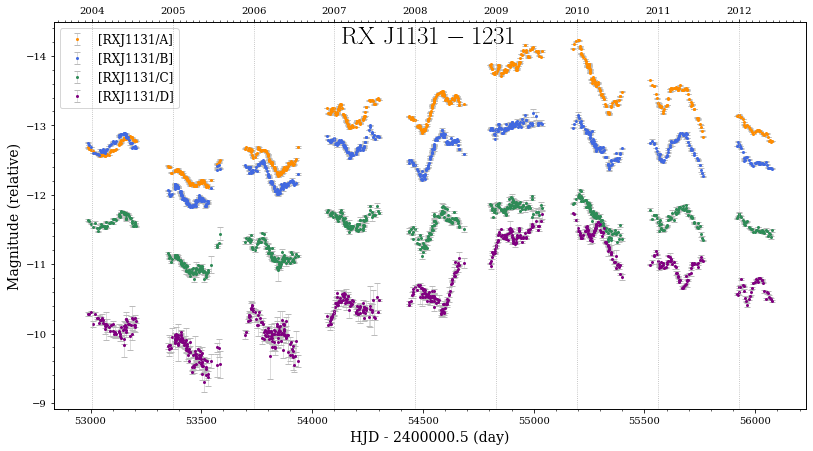

In [4]:
# Display info and unshifted light curves
print(rxj1131_lcs[0].longinfo())
pycs3.gen.mrg.colourise(rxj1131_lcs)

# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
    
pycs3.gen.lc_func.display(rxj1131_lcs, figsize=(19/1.6,10/1.6), nicefont=True, showdates=True, showgrid=True, markersize=4, title=r'$\mathrm{RX\ J1131-1231}$')#, filename='../figures/rxj1131_lcdata.png')

## Spline method

Optimising function, `opt_fine` assumes no more than 10d initial delay from true value

In [10]:
# Spline optimization
def spl(lcs, kn_r, kn_f):
    # opt_fine: supposes that lcs are within 10 days of true delays
    spline = pycs3.spl.topopt.opt_rough(lcs, nit=5, knotstep=kn_r, verbose=False)
    spline = pycs3.spl.topopt.opt_fine(lcs, nit=5, knotstep=kn_f, verbose=False)
    return spline

### Spline fit, without microlensing. 
Add initial guess if not using `opt_rough`

Starting ML optimization ...
Done !


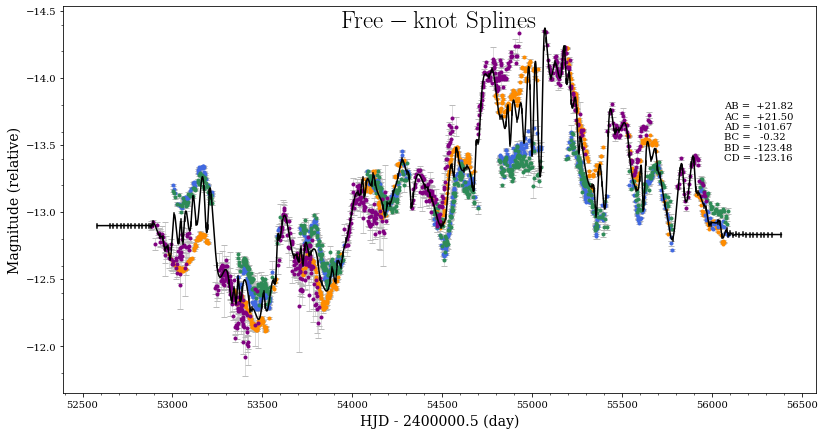

Time delays:
AB =  +21.82
AC =  +21.50
AD = -101.67
BC =   -0.32
BD = -123.48
CD = -123.16


In [11]:
# Spline fit 
        
# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()    
    
# We apply initial timeshift guesses
pycs3.gen.lc_func.applyshifts(rxj1131_lcs, [0,0,0,-90], [0,0,0,0])

knotstep_r = 40
knotstep_f = 20

spline = spl(rxj1131_lcs, knotstep_r, knotstep_f)
pycs3.gen.lc_func.display(rxj1131_lcs, [spline], figsize=(19/1.6,10/1.6), showdelays=True, showlegend=False,title=r'$\mathrm{Free-knot\ Splines}$')#, filename='../figures/rxj1131_splineoptnoml.png')

print('Time delays:')
print(pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True))

### Spline fit, with added spline to model microlensing
Play with `mlknotstep` for initial knot spacing of ml spline

Starting ML optimization ...
Working on the spline ML of [RXJ1131/A]|~3/u/19~|
Working on the spline ML of [RXJ1131/B](0.000,-0.455,0)|~3/u/19~|
Working on the spline ML of [RXJ1131/C](0.000,-1.525,0)|~3/u/19~|
Working on the spline ML of [RXJ1131/D](-90.000,-2.618,0)|~3/u/19~|
Done !
Wrote ../data/sploptcurves.pkl


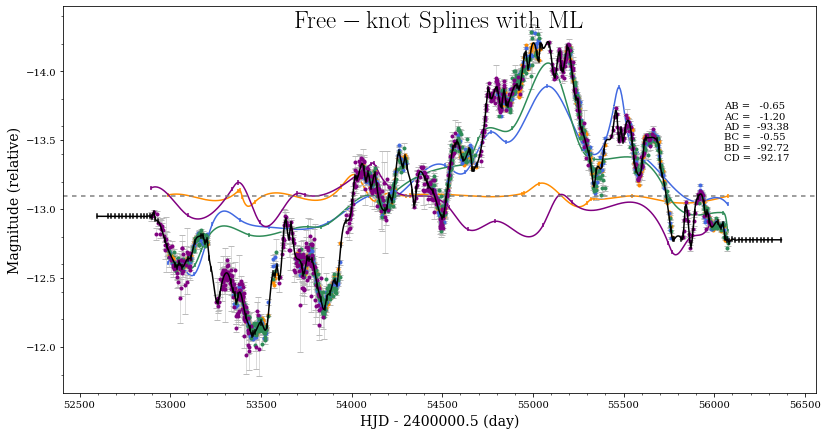

Time delays:
AB =   -0.65
AC =   -1.20
AD =  -93.38
BC =   -0.55
BD =  -92.72
CD =  -92.17


In [12]:
# Spline microlensing

# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
    
    
knotstep_r = 40    # opt_rough knotstep
knotstep_f = 20    # opt_fine knotstep
mlknotstep = 150   # initial ml knotstep

# We apply initial timeshift guesses
pycs3.gen.lc_func.applyshifts(rxj1131_lcs, [0,0,0,-90], [0,0,0,0])

# attach microlensing splines to lcs A, B, C, D
for lc in rxj1131_lcs[:] : 
    pycs3.gen.splml.addtolc(lc, knotstep=mlknotstep) #we attach microlensing to the LightCurve object
    
spline = spl(rxj1131_lcs, knotstep_r, knotstep_f)
pycs3.gen.util.writepickle([rxj1131_lcs, spline], '../data/sploptcurves.pkl')

pycs3.gen.lc_func.display(rxj1131_lcs, [spline], figsize = (19/1.6,10/1.6), showdelays=True,
                         showlegend=False, title=r'$\mathrm{Free-knot\ Splines\ with\ ML}$', collapseref=True)#, filename='../figures/rxj1131_splineoptml.png')
print("Time delays:")
print(pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True))

## Gaussian process method
GP regression by random sampling of light curves. Available kernels : `matern`, `RBF`, `RatQuad`

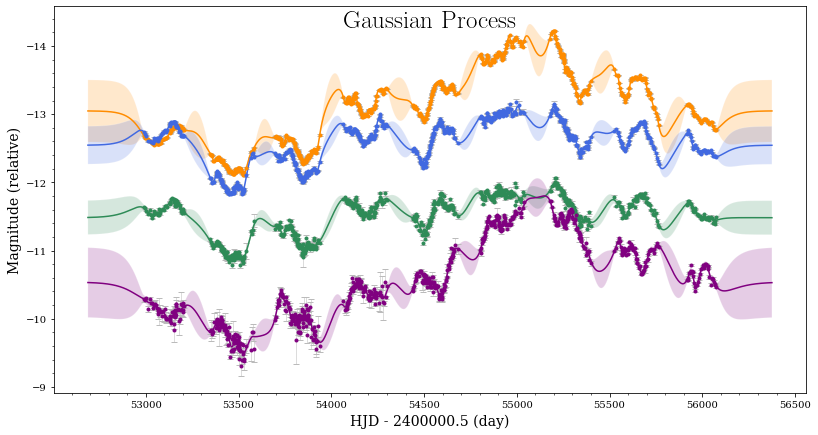

In [5]:
# Gaussian process fit
            
# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
    
kwargs_reg = {'pd': 1, 'covkernel': 'matern', 'pow': 1.5, 'amp': 1., 'scale': 200., 'errscale': 1, 'verbose': True, 'method': 'weights'}

rslcs = [pycs3.regdiff.rslc.factory(l, pd=kwargs_reg['pd'], covkernel=kwargs_reg['covkernel'], 
                                    pow=kwargs_reg['pow'], errscale=kwargs_reg['errscale']) for l in rxj1131_lcs]

pycs3.gen.lc_func.display(rxj1131_lcs, rslcs, figsize=(19/1.6,10/1.6), title=r'$\mathrm{Gaussian\ Process}$', showlegend=False)#, filename='../figures/rxj1131_gp.png')

### Regdiff optimization
Minimize residuals of lc substraction to obtain time delay measure

Time delays:
AB =   +0.50
AC =   +0.00
AD =  -91.72
BC =   -0.50
BD =  -92.22
CD =  -91.72


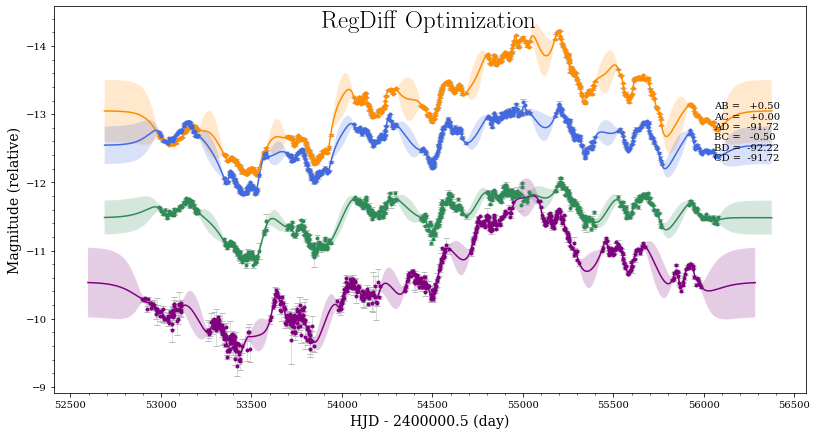

In [6]:
# Regdiff optimization

# Optimization function
def regdiff(lcs, **kwargs):
    return pycs3.regdiff.multiopt.opt_ts(lcs, pd=kwargs['pd'], covkernel=kwargs['covkernel'], pow=kwargs['pow'],
                                        errscale=kwargs['errscale'], verbose=False, method='weights')

# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
#                                          timeshift           magshift
pycs3.gen.lc_func.applyshifts(rxj1131_lcs, [0., 0, 0, -90.], [0.,0.,0.,0.])  

rslcs, error_fct = regdiff(rxj1131_lcs, pd=2, covkernel='matern', pow=1.5,errscale=1)
print("Time delays:")
print(pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True))
pycs3.gen.lc_func.display(rxj1131_lcs, rslcs, figsize=(19/1.6,10/1.6), title=r'$\mathrm{RegDiff\ Optimization}$', showlegend=False, showdelays=True)#, filename='../figures/rxj1131_gp.png')

Display interpolated, shifted curves and residuals

Text(0, 0.5, '$m_A - m_D$ \n $\\mathrm{(mag)}$')

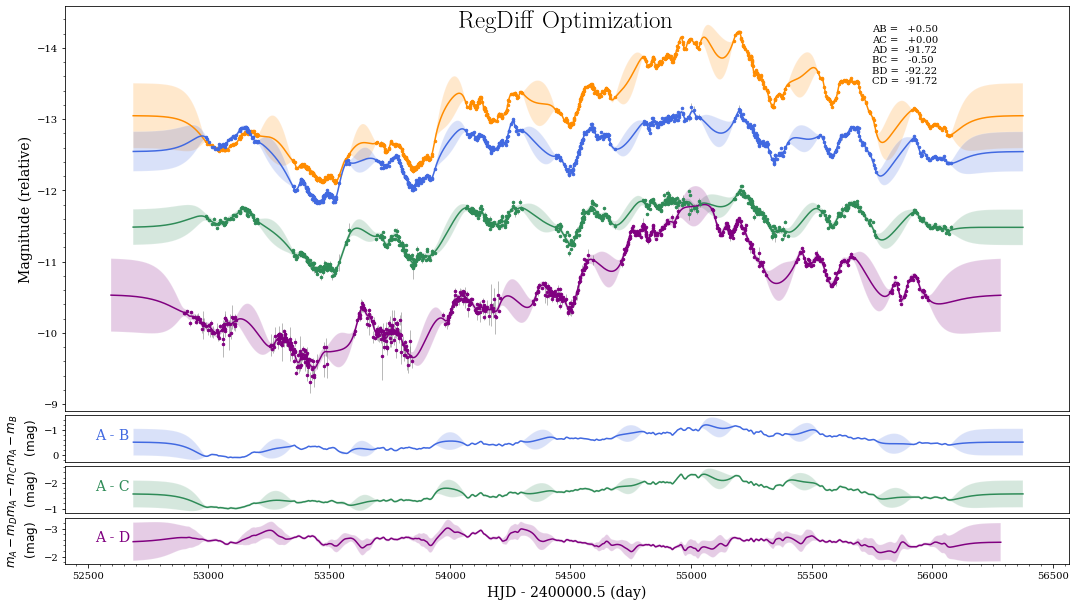

In [7]:
# Light curves already timeshifted
rslcs = [pycs3.regdiff.rslc.factory(l, pd=kwargs_reg['pd'], covkernel=kwargs_reg['covkernel'],
                                   pow=kwargs_reg['pow'], amp=kwargs_reg['amp'], scale=kwargs_reg['scale'], errscale=kwargs_reg['errscale']) for l in rxj1131_lcs]

rslcs_residuals = [pycs3.regdiff.rslc.subtract(rslcs[0],rslcs[i]) for i in [1,2,3]]

# Figure panel
fig1 = plt.figure(figsize=(19/1.2,10/1.2))
gs1 = gridspec.GridSpec(11,2)
gs1.update(left=0.08, right=0.96, top=0.98, bottom=0.05, wspace=0.05, hspace=0.09)
ax1 = plt.subplot(gs1[:8, :])
ax2 = plt.subplot(gs1[8:9, :], sharex=ax1)
ax3 = plt.subplot(gs1[9:10, :], sharex=ax1)
ax4 = plt.subplot(gs1[10:11, :], sharex=ax1)

# colorize residuals curves
for j, lc in enumerate(rslcs_residuals):
    lc.plotcolour = rxj1131_lcs[j+1].plotcolour
    
# prepare legend for different curves
disptext = []
for j, lc in enumerate(rslcs_residuals):
    ycoord = 0.5
    xcoord = 0.03
    kwargs = {'fontsize': 14, 'color': rxj1131_lcs[j+1].plotcolour}
    txt = f'A - {rxj1131_lcs[j+1].object}'
    disptext.append((xcoord, ycoord, txt, kwargs))

pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True)
    
# plot light curves, regressions, and differences curves
pycs3.gen.lc_func.display(rxj1131_lcs, rslcs, showdelays=False, showlegend=False,
                         title=r'$\mathrm{RegDiff\ Optimization}$', filename='screen', ax=ax1, style='cosmograil_dr1')
pycs3.gen.lc_func.display([], [rslcs_residuals[0]], showdelays=False, showlegend=False, filename='screen', ax=ax2, style='cosmograil_dr1', text=[disptext[0]])
pycs3.gen.lc_func.display([], [rslcs_residuals[1]], showdelays=False, showlegend=False, filename='screen', ax=ax3, style='cosmograil_dr1', text=[disptext[1]])
pycs3.gen.lc_func.display([], [rslcs_residuals[2]], showdelays=False, showlegend=False, filename='screen', ax=ax4, style='cosmograil_dr1', text=[disptext[2]])

ax1.annotate(pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True), (55750,-13.5))

# adjust the axis
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.set_ylabel(f'$m_{rxj1131_lcs[0].object[0]} - m_{rxj1131_lcs[1].object[-1]}$ \n $\mathrm{{(mag)}}$', fontsize=12)
ax3.get_xaxis().set_visible(False)
ax3.set_ylabel(f'$m_{rxj1131_lcs[0].object[0]} - m_{rxj1131_lcs[2].object[-1]}$ \n $\mathrm{{(mag)}}$', fontsize=12)
ax4.set_ylabel('Regression Difference \n Residuals (mag)', fontsize=9)
ax4.set_ylabel(f'$m_{rxj1131_lcs[0].object[0]} - m_{rxj1131_lcs[3].object[-1]}$ \n $\mathrm{{(mag)}}$', fontsize=12)
# plt.tight_layout()
# plt.savefig('../figures/rxj1131_regdiff.svg', format='svg', dpi=1200)

In [ ]:
# Save optimized curves in pickle file
# pycs3.gen.util.writepickle([rxj1131_lcs, rslcs], "../data/optcurves.pkl")

## Drawing copies from optimized splines
In order to learn intrinsic variance of CS technique, draw 2 pkl files with 10 copies of the data (identical, same TS and ML, no added noise).

In [15]:
# Drawing copies
simfolder="../data/sim0"

if not os.path.isdir(simfolder):
    os.mkdir(simfolder)
    
lcs, spline = pycs3.gen.util.readpickle("../data/sploptcurves.pkl")
pycs3.sim.draw.multidraw(lcs, onlycopy=True, n=10, npkl=1, simset='copies', destpath=simfolder)

Read ../data/sploptcurves.pkl
Now thowing dice into ../data/sim0/sims_copies ...
The directory exists, I'll add my new curves.
Input shifts :
A    -0.68 | B    -1.34 | C    -1.88 | D   -94.06
Input delays :
AB =   -0.65 | AC =   -1.20 | AD =  -93.38 | BC =   -0.55 | BD =  -92.72 | CD =  -92.17
Preparing 10 identical copies for pkl 1/1 ...
Wrote ../data/sim0/sims_copies/1_1619640427.16498.pkl


Run estimator from different starting points in range $\pm$ 10 days around previously measured time shifts 


In [16]:
kwargs_opt_spl = {'kn_r':knotstep_r,'kn_f':knotstep_f}
kwargs_opt_reg = {'pd': 2, 'covkernel': 'matern', 'pow': 1.5, 'amp': 1, 'scale': 200, 'errscale': 1}

# success_dic = pycs3.sim.run.multirun('copies', lcs, spl, kwargs_opt_spl, optset='spl', tsrand=10.0, keepopt=True, destpath=simfolder)
success_dic = pycs3.sim.run.multirun('copies', lcs, regdiff, kwargs_opt_reg, optset='reg', tsrand=10.0, keepopt=True, destpath=simfolder)

I have found 5 simulation pickles in ../data/sim0/sims_copies.
I'll write my results into the directory ../data/sim0/sims_copies_opt_reg.
(The latter already exists.)
Initial conditions : 
[RXJ1131/A](-0.680,0.000,0)|~3/7l7b/19~|
[RXJ1131/B](-1.335,-0.455,0)|~3/7l7b/19~|
[RXJ1131/C](-1.884,-1.525,0)|~3/7l7b/19~|
[RXJ1131/D](-94.058,-2.618,0)|~3/7l7b/19~|
--- Casino running on simset copies, optset reg ---
Read ../data/sim0/sims_copies/1_1619640427.16498.pkl
Working for ../data/sim0/sims_copies_opt_reg/1_1619640427.16498_runresults.pkl, 10 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...
Shifted 10/10 simulations, time : 275
Wrote ../data/sim0/sims_copies_opt_reg/1_1619640427.16498_opt.pkl
Wrote ../data/sim0/sims_copies_opt_reg/1_1619640427.16498_runresults.pkl


### Collecting the results, displaying histograms

Reading 2 runresult pickles...
OK, I have collected 20 runs from Regression difference technique
Reading 2 runresult pickles...
OK, I have collected 20 runs from Free-knot spline technique
Wrote ../data/sim0/sims_copies_opt_reg_delays.pkl
Wrote ../data/sim0/sims_copies_opt_spl_delays.pkl
Plotting "Regression difference technique (Measured, 20) "
     Labels : A, B, C, D
     Median shifts : -0.19, 0.27, -0.26, -91.95
     Std shifts : 4.45, 4.44, 4.49, 4.46
Plotting "Free-knot spline technique (Measured, 20) "
     Labels : A, B, C, D
     Median shifts : -1.50, -2.09, -2.37, -95.13
     Std shifts : 3.72, 3.66, 3.74, 3.57


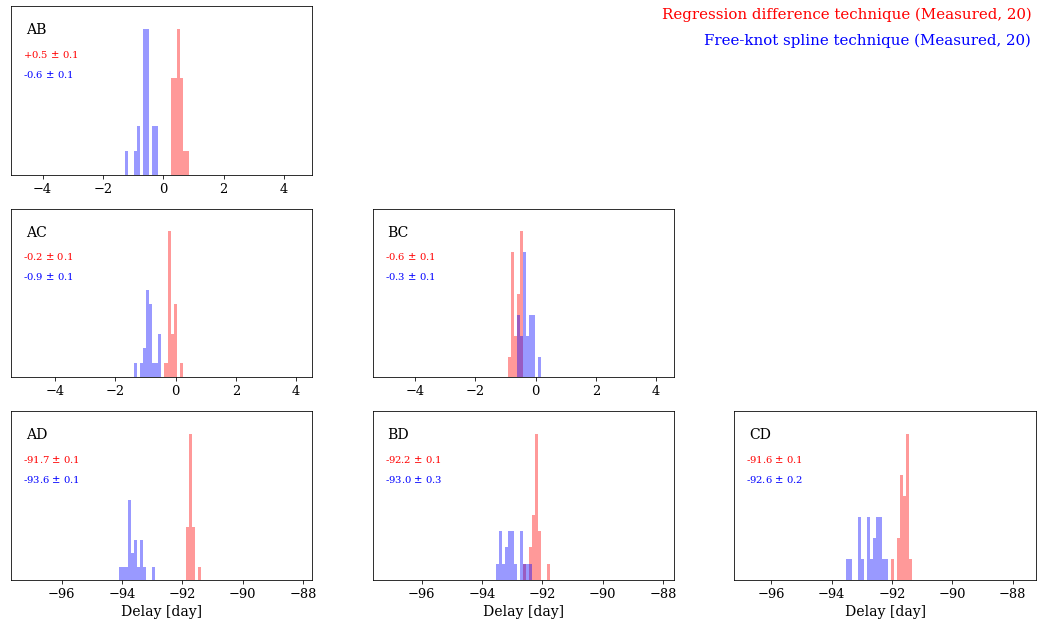

In [16]:
dataresults = [
    pycs3.sim.run.collect(directory=os.path.join(simfolder, 'sims_copies_opt_reg'), plotcolour='red', name='Regression difference technique'),
    pycs3.sim.run.collect(directory=os.path.join(simfolder, 'sims_copies_opt_spl'), plotcolour='blue', name='Free-knot spline technique')
]

pycs3.sim.plot.hists(dataresults, r=5.0, nbins=100, showqs=False, dataout=True, usemedian=True, outdir=simfolder)

__Note__ : variance in histograms above does not represent uncertainty in the results, but rather the intrinsic variance of the estimators. Recall that the curves in this case were completely identical except for random time shifts $\Delta t \in [-10,10]$ days on B,C and D.

To properly estimate uncertainties, need to generate mock light curves with randomized noise.

# Drawing mocks

Generate mocks, built on same intrinsic and extrinsic spline model than the data, but with randomized noise. 

Two functions for the noise generative model:
 - `pycs3.sim.twk.tweakspl` : inserts mixture of "colored noise" with slope of the power spectrum controlled by `beta` and white noise amplitude controlled by `sigma`. These parameters can be adjusted to match data properties in term of random and correlated noise.
 - `pycs3.sim.twk.tweakml_PS` : uses power spectrum of residual of fit (lc points - spline) to inject noise in simulated curves with same power spectrum, but randomized phases. Max frequency `B` in units of Nyquist freq and correction factor to amplitude of power spectrum `A_correction` need to be adjusted.
 
These functions are then used to generate mock curves, shifted in time by random ts chosen in interval `truestr` $\in [-10,10]$ days around measured delay.

In [17]:
# Mock light curve generation

# We use tweakspl
def Atweakml(lcs, spline):
    return pycs3.sim.twk.tweakml(lcs, spline, beta=-1.5, sigma=0.25, fmin=1/500, fmax=None, psplot=False)

def Btweakml(lcs, spline):
    return pycs3.sim.twk.tweakml(lcs, spline, beta=-1.0, sigma=0.9, fmin=1/500, fmax=None, psplot=False)

def Ctweakml(lcs, spline):
    return pycs3.sim.twk.tweakml(lcs, spline, beta=-1.0, sigma=1.5, fmin=1/500, fmax=None, psplot=False)

def Dtweakml(lcs, spline):
    return pycs3.sim.twk.tweakml(lcs, spline, beta=-4.5, sigma=4.5, fmin=1/500, fmax=None, psplot=False)

pycs3.sim.draw.saveresiduals(lcs, spline)
pycs3.sim.draw.multidraw(lcs, spline=spline, n=5, npkl=2, simset='mock',
                        truetsr=10, tweakml=[Atweakml, Btweakml, Ctweakml, Dtweakml], destpath=simfolder)

Now thowing dice into ../data/sim0/sims_mock ...
The directory exists, I'll add my new curves.
Input shifts :
A    -0.68 | B    -1.34 | C    -1.88 | D   -94.06
Input delays :
AB =   -0.65 | AC =   -1.20 | AD =  -93.38 | BC =   -0.55 | BD =  -92.72 | CD =  -92.17
Drawing 5 simulations for pkl 1/2 ...
Wrote ../data/sim0/sims_mock/1_1619641872.90579.pkl
Drawing 5 simulations for pkl 2/2 ...
Wrote ../data/sim0/sims_mock/2_1619641873.72223.pkl


## Optimizing the mock curves

In [19]:
# success_dic = pycs3.sim.run.multirun('mock', lcs, spl, kwargs_opt_spl, optset='spl', tsrand=10, keepopt=True, destpath=simfolder)
success_dic = pycs3.sim.run.multirun('mock', lcs, regdiff, kwargs_opt_reg, optset='reg', tsrand=10, keepopt=True, destpath=simfolder)

I have found 22 simulation pickles in ../data/sim0/sims_mock.
I'll write my results into the directory ../data/sim0/sims_mock_opt_reg.
Initial conditions : 
[RXJ1131/A](-0.680,0.000,0)|~3/7l7b/19~|
[RXJ1131/B](-1.335,-0.455,0)|~3/7l7b/19~|
[RXJ1131/C](-1.884,-1.525,0)|~3/7l7b/19~|
[RXJ1131/D](-94.058,-2.618,0)|~3/7l7b/19~|
--- Casino running on simset mock, optset reg ---
Read ../data/sim0/sims_mock/10_1619213723.20553.pkl
Working for ../data/sim0/sims_mock_opt_reg/10_1619213723.20553_runresults.pkl, 5 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...
Shifted 5/5 simulations, time : 146
Wrote ../data/sim0/sims_mock_opt_reg/10_1619213723.20553_opt.pkl
Wrote ../data/sim0/sims_mock_opt_reg/10_1619213723.20553_runresults.pkl
--- Casino running on simset mock, optset reg ---
Read ../data/sim0/sims_mock/10_1619213973.00469.pkl
Working for ../data/sim0/sims_mock_opt_reg/10_1619213973.00469_runresults.pkl, 5 simulations.
Starting the curve shifting on a single CPU

KeyboardInterrupt: 